## 네이버 영화리뷰 감성분석

0. 라이브러리

In [129]:
import konlpy
import gensim
import pandas as pd
import tensorflow as tf

1. 데이터 준비

In [146]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [145]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


2. 데이터 로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [147]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [148]:
# 기존 사전의 키 벨류에서 반대 - 인덱스에서 워드로
index_to_word = {index:word for word, index in word_to_index.items()}

In [115]:
### check
index_to_word[0]

'<PAD>'

In [149]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [150]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


In [156]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 54)


4. 모델 구성 및 validation set 구성

In [173]:
split_ratio = 0.2
split_index = int(len(X_train) * split_ratio)

x_val = X_train[:split_index]   
y_val = y_train[:split_index]

partial_x_train = X_train[split_index:]  
partial_y_train = y_train[split_index:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116946, 54)
(116946,)


In [174]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [175]:
# Conv model 설계 
model_1 = tf.keras.Sequential()

model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(tf.keras.layers.MaxPooling1D(5))
model_1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(tf.keras.layers.GlobalMaxPooling1D())
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 16)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_53 (Dense)             (None, 1)               

In [176]:
# RNN model 설계 
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 54, 100)           1000000   
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 25, 100)           300100    
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 1,301,733
Trainable params: 1,301,733
Non-trainable params: 0
_________________________________________________________________


In [177]:
# Conv+GlobalMaxPooling model설계 
model_3 = tf.keras.Sequential()

model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_26 (Glo (None, 16)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 9         
Total params: 161,953
Trainable params: 161,953
Non-trainable params: 0
_________________________________________________________________


In [178]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 2s 6ms/step - loss: 0.5099 - accuracy: 0.7688 - val_loss: 0.3624 - val_accuracy: 0.8416
Epoch 2/5
229/229 [==============================] - 1s 5ms/step - loss: 0.3340 - accuracy: 0.8580 - val_loss: 0.3399 - val_accuracy: 0.8526
Epoch 3/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2953 - accuracy: 0.8782 - val_loss: 0.3376 - val_accuracy: 0.8546
Epoch 4/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2678 - accuracy: 0.8916 - val_loss: 0.3407 - val_accuracy: 0.8555
Epoch 5/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2431 - accuracy: 0.9034 - val_loss: 0.3477 - val_accuracy: 0.8544


In [179]:
results = model_3.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3581 - accuracy: 0.8520
[0.35812830924987793, 0.8520048260688782]


In [180]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


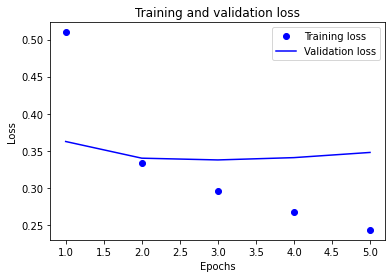

In [181]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

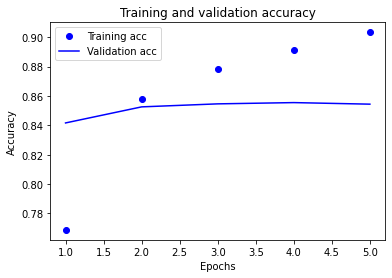

In [182]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

word2vec 

In [183]:
embedding_layer = model_3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [184]:
for i in range(10):
    word_vector = weights[i]
    print(f"Word {i}: {word_vector}")

Word 0: [ 0.00218144 -0.06741945  0.01013934  0.08649914  0.01447986  0.00804597
 -0.02439931 -0.15335943 -0.15416355 -0.00586777 -0.06574634 -0.06174804
  0.06314476 -0.03059609 -0.07327874  0.02701615]
Word 1: [-0.03432568 -0.00920862 -0.04499134  0.03196852 -0.03997704 -0.02784364
 -0.03082265 -0.00593587 -0.02080048 -0.03064071  0.02968726 -0.04085833
 -0.02196076 -0.02729588  0.00190366  0.00950663]
Word 2: [-0.03548691  0.04198248 -0.0463877  -0.04326544  0.04936019 -0.00033035
  0.02242826  0.00356437  0.03889013 -0.03782557 -0.02937325  0.04155057
 -0.0439965  -0.03164371  0.02488213  0.01400533]
Word 3: [-0.05190344 -0.02062185  0.01246174  0.01902429  0.01618334  0.01175209
 -0.03013178 -0.05160873  0.00925499  0.01086225 -0.02728455 -0.02639049
  0.01351918 -0.03224613 -0.02910995  0.05340317]
Word 4: [-0.03851902 -0.01672361 -0.00627702  0.07067257 -0.00861586  0.0573836
  0.05839438  0.02673732 -0.09392253 -0.09620036  0.03385825  0.12808505
 -0.01307265 -0.04752755  0.047

한국어 워드투벡 적용

In [185]:
import os
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = KeyedVectors.load(word2vec_path)

In [186]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [187]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(100, 30, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 54, 100)           1000000   
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 25, 100)           300100    
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 1,301,733
Trainable params: 1,301,733
Non-trainable params: 0
_________________________________________________________________


In [193]:
# 복잡도를 추가한 RNN model 설계 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(30))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 54, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_62 (Dense)             (None, 8)                 248       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 9         
Total params: 1,015,977
Trainable params: 1,015,977
Non-trainable params: 0
_________________________________________________________________


In [194]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 3s 9ms/step - loss: 0.5173 - accuracy: 0.7370 - val_loss: 0.4113 - val_accuracy: 0.8139
Epoch 2/10
229/229 [==============================] - 2s 7ms/step - loss: 0.3805 - accuracy: 0.8307 - val_loss: 0.3681 - val_accuracy: 0.8357
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.3360 - accuracy: 0.8542 - val_loss: 0.3569 - val_accuracy: 0.8450
Epoch 4/10
229/229 [==============================] - 2s 7ms/step - loss: 0.3099 - accuracy: 0.8686 - val_loss: 0.3455 - val_accuracy: 0.8480
Epoch 5/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2904 - accuracy: 0.8780 - val_loss: 0.3400 - val_accuracy: 0.8526
Epoch 6/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2752 - accuracy: 0.8869 - val_loss: 0.3521 - val_accuracy: 0.8512
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2615 - accuracy: 0.8931 - val_loss: 0.3476 - val_accuracy: 0.8518
Epoch 

In [195]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3607 - accuracy: 0.8530
[0.3607332408428192, 0.8530423045158386]
